# Pre-processing and analysis of single-cell RNA-seq data with kallisto|bustools.

In this notebook, we will perform pre-processing and analysis of [mouse retinal cells SRR8599150](https://www.ncbi.nlm.nih.gov/sra/?term=SRR8599150) dataset from [Koren et al., 2019](https://doi.org/10.1016/j.immuni.2019.02.007) using the **kallisto | bustools** workflow, implemented with a wrapper called `kb`. It was developed by Kyung Hoi (Joseph) Min and A. Sina Booeshaghi.

In [0]:
!date

Wed Dec 11 19:24:56 UTC 2019


## Pre-processing

### Download the data

__Note:__ We use the `-O` option for `wget` to rename the files to easily identify them.

In [0]:
%%time
!wget https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt -O checksums.txt
!wget https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz -O SRR8599150_S1_L001_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz -O SRR8599150_S1_L001_R2_001.fastq.gz

--2019-12-11 19:55:24--  https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Resolving caltech.box.com (caltech.box.com)... 185.235.236.197
Connecting to caltech.box.com (caltech.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt [following]
--2019-12-11 19:55:24--  https://caltech.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt [following]
--2019-12-11 19:55:25--  https://caltech.app.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Resolving caltech.app.box.com (caltech.app.box.com)... 185.235.236.199
Connecting to caltech.app.box.com (caltech.app.box.com)|185.235.236.199|:443... connected.
HTTP request sent, awaiting response.

Then, we verify the integrity of the files we downloaded to make sure they were not corrupted during the download.

In [0]:
!md5sum -c checksums.txt --ignore-missing

SRR8599150_S1_L001_R1_001.fastq.gz: OK
SRR8599150_S1_L001_R2_001.fastq.gz: OK


### Install `kb`
Install `kb` for running the kallisto|bustools workflow.

In [0]:
!pip install kb-python

     |████████████████████████████████| 35.4MB 2.0MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47896 sha256=8d9ba2fe9dd0a2d7a58a2a72811cc1eda3b20ff3476cf31b721e5dbfe0a170e1
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=27879 sha256=ff096fcefa43b155d38212e01b0d5c80d221ecd0a49f8a10bf1a996f1b1fe16d
  Stored in directory: /root/.cache/pip/wheels/6c/fb/3d/5c43eb691bd92a3ddd0ebeb6e7e78ceaf3ae1cb8d54b89a7fb
Successfully built loompy numpy-groupies


### Download a pre-built mouse index

__Note:__ See [this notebook](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_transcriptome_index.ipynb) for a tutorial on how to build custom transcriptome or RNA velocity indices.

In [0]:
%%time
!kb ref -d mouse -i index.idx -g t2g.txt

[2019-12-11 19:26:40,656]    INFO Downloading files for mouse from https://caltech.box.com/shared/static/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz to tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
[2019-12-11 19:29:27,539]    INFO Extracting files from tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
CPU times: user 983 ms, sys: 145 ms, total: 1.13 s
Wall time: 3min 19s


### Generate an RNA count matrix in H5AD format

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store [Anndata](https://anndata.readthedocs.io/en/stable/) objects. Notice we are providing the index and transcript-to-gene mapping we downloaded in the previous step to the `-i` and `-g` arguments respectively. Also, these reads were generated with the 10x Genomics Chromium Single Cell v2 Chemistry, hence the `-x 10xv2` argument. To view other supported technologies, run `kb --list`.

__Note:__ If you would like a Loom file instead, replace the `--h5ad` flag with `--loom`. If you want to use the raw matrix output by `kb` instead of their H5AD or Loom converted files, omit these flags.

In [0]:
%%time
!kb count -i index.idx -g t2g.txt -x 10xv2 --h5ad -t 2 \
SRR8599150_S1_L001_R1_001.fastq.gz SRR8599150_S1_L001_R2_001.fastq.gz

[2019-12-11 19:30:00,707]    INFO Generating BUS file from
[2019-12-11 19:30:00,708]    INFO         SRR8599150_S1_L001_R1_001.fastq.gz
[2019-12-11 19:30:00,708]    INFO         SRR8599150_S1_L001_R2_001.fastq.gz
[2019-12-11 19:33:13,111]    INFO Sorting BUS file ./output.bus to tmp/output.s.bus
[2019-12-11 19:33:17,052]    INFO Whitelist not provided
[2019-12-11 19:33:17,052]    INFO Copying pre-packaged 10XV2 whitelist to .
[2019-12-11 19:33:17,159]    INFO Inspecting BUS file tmp/output.s.bus
[2019-12-11 19:33:19,321]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist ./10xv2_whitelist.txt
[2019-12-11 19:33:42,187]    INFO Sorting BUS file tmp/output.s.c.bus to ./output.unfiltered.bus
[2019-12-11 19:33:45,666]    INFO Generating count matrix ./counts_unfiltered/cells_x_genes from BUS file ./output.unfiltered.bus
[2019-12-11 19:33:48,353]    INFO Converting matrix ./counts_unfiltered/cells_x_genes.mtx to h5ad ./counts_unfiltered/adata.h5ad
CPU tim

## Analysis

In this part of the tutorial, we will load the RNA count matrix generated by `kb count` into Python and cluster the cells with Louvain.

### Install packages

Google Colab does not come with `Scanpy`, `python-igraph`, or `louvain` (but comes with `matplotlib`, `numpy`, `pandas`, and `scipy`).

In [0]:
%%time
!pip install scanpy python-igraph louvain MulticoreTSNE

     |████████████████████████████████| 1.9MB 6.8MB/s 
     |████████████████████████████████| 378kB 42.7MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████| 13.0MB 27.6MB/s 
     |████████████████████████████████| 3.6MB 41.4MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.7.1.post6-cp36-cp36m-linux_x86_64.whl size=2221497 sha256=a7d1858924a8b834f3d1480e986f83c2bed45cc40acf82a505795438444f8f3c
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
  Created wheel for louvain: filename=louvain-0.6.1-cp36-cp36m-linux_x86_64.whl size=1026890 sha256=d3c1d7078073218f0cebe272d4c33020eb62dd0313d8aaa5d1afdc026cbf8adb
  Stored in directory: /root/.cache/pip/wheels/f2/c3/d4/f7abaf064186d6214ef952bbb72fd6c5136d4b17dbeaeff481
Successfully built python-igraph louvain
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.

CPU times: user 2.23 s, sys: 229 ms, total: 2.46 s
Wall time: 6min 14s


### Import packages

In [0]:
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse, io

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

### Import H5AD-formatted Anndata matrix

In [0]:
adata = anndata.read('counts_unfiltered/adata.h5ad')

In [0]:
adata

AnnData object with n_obs × n_vars = 96775 × 55421 

### Make the knee plot

In [0]:
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

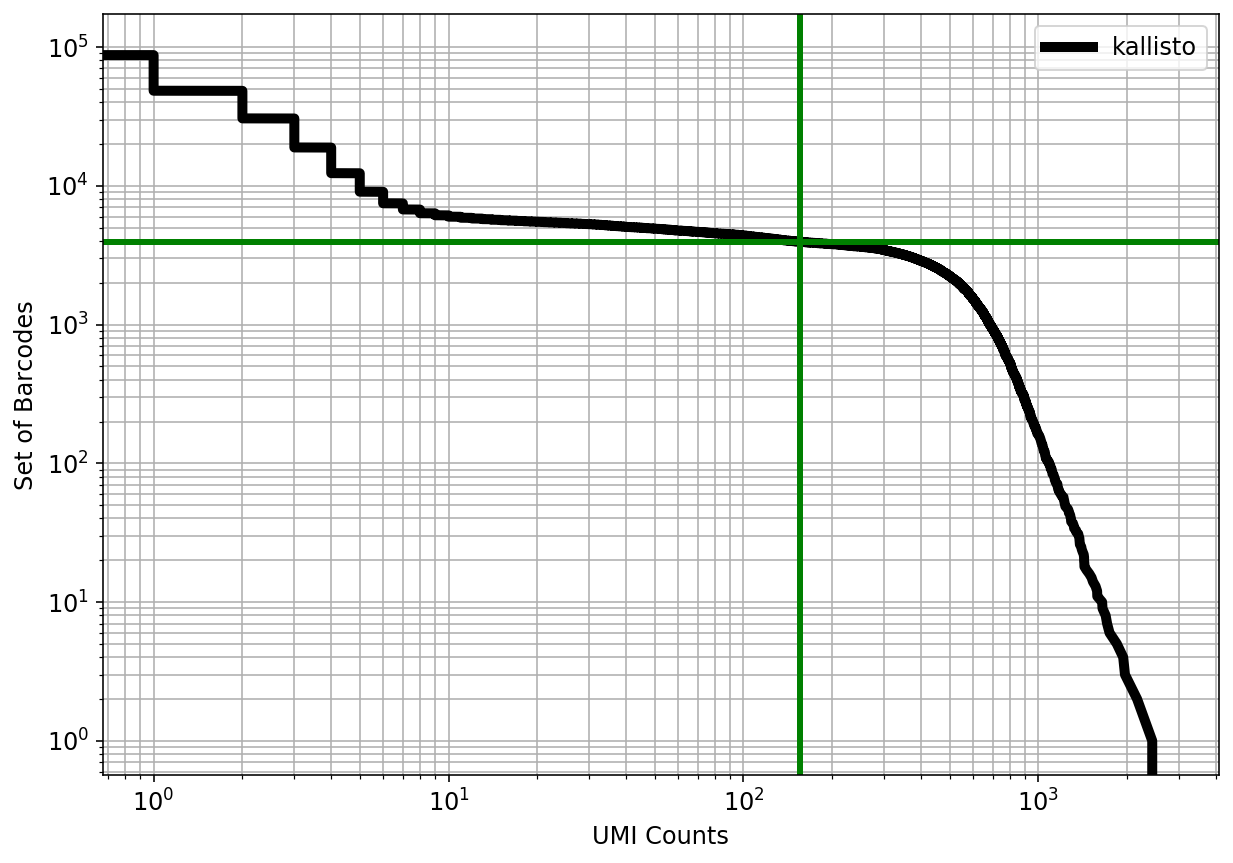

In [0]:
fig, ax = plt.subplots(figsize=(10, 7))

expected_num_cells=3949

ax.loglog(knee, range(len(knee)), label="kallisto", linewidth=5, color="k")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="g")
ax.axhline(y=expected_num_cells, linewidth=3, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
ax.legend()
plt.show()

### Filter with ScanPy

In [0]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=knee[expected_num_cells])
sc.pp.filter_genes(adata, min_cells=0)

In [0]:
adata

AnnData object with n_obs × n_vars = 3950 × 55421 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells'

### Visualize gene and count distributions

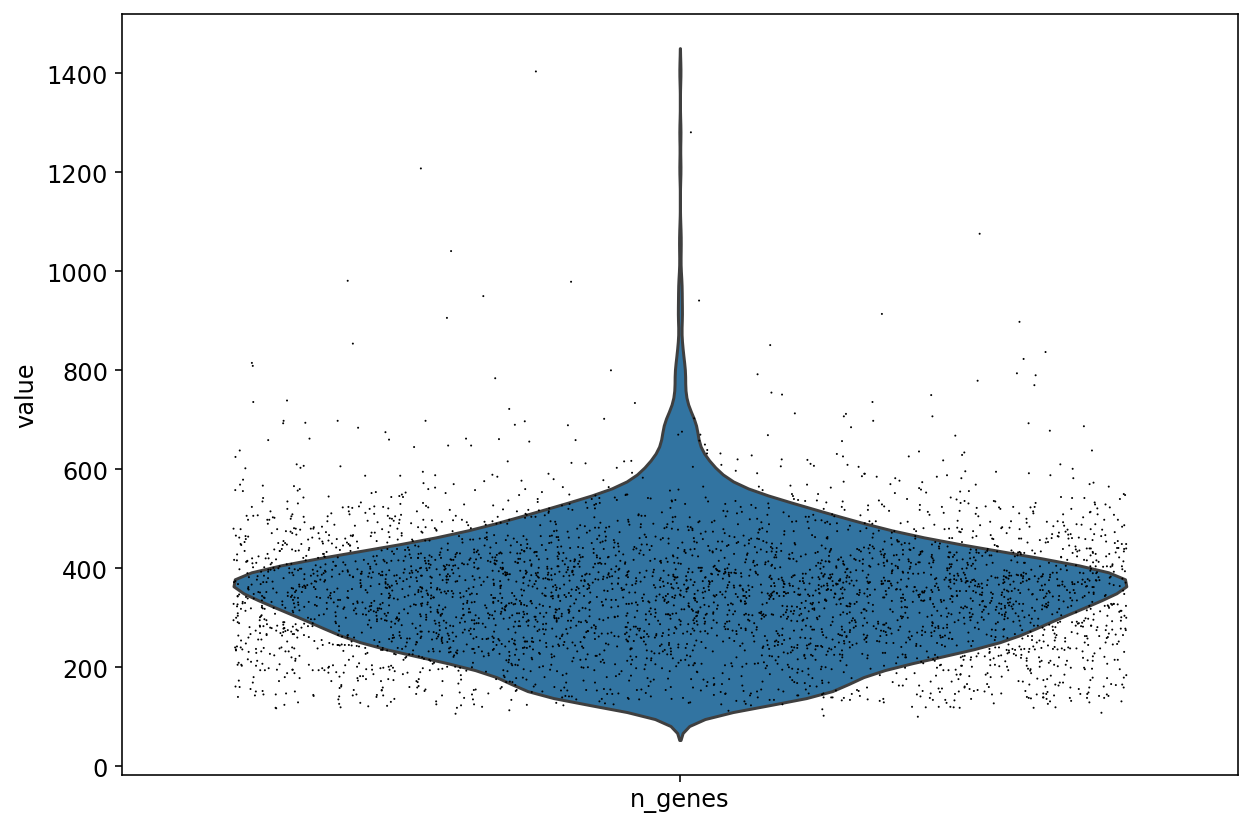

In [0]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.violin(adata, 'n_genes', jitter=0.4, ax=ax)

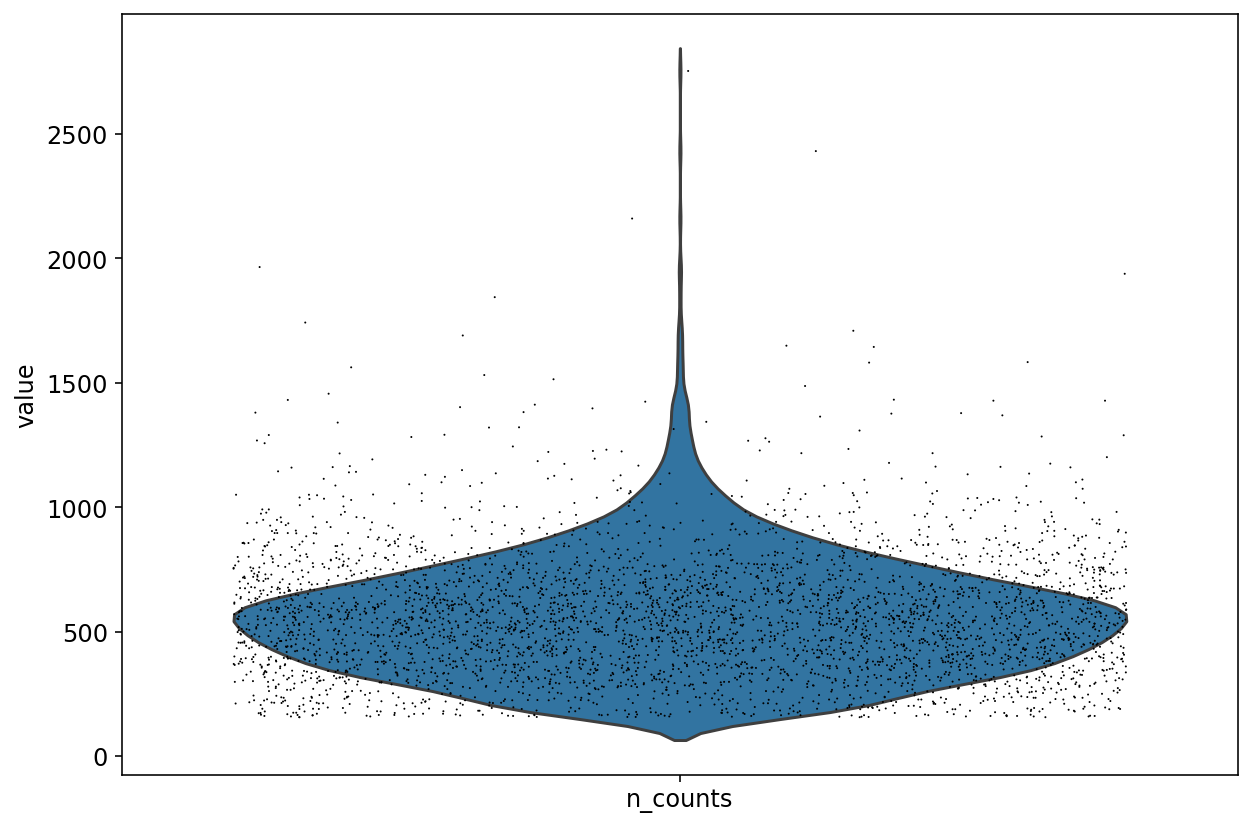

In [0]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.violin(adata, 'n_counts', jitter=0.4, ax=ax)

### Normalize the counts in the matrix

In [0]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# apply log(1 + count) to all counts
adata.raw = sc.pp.log1p(adata, copy=True)
sc.pp.log1p(adata)

### View highly variable genes

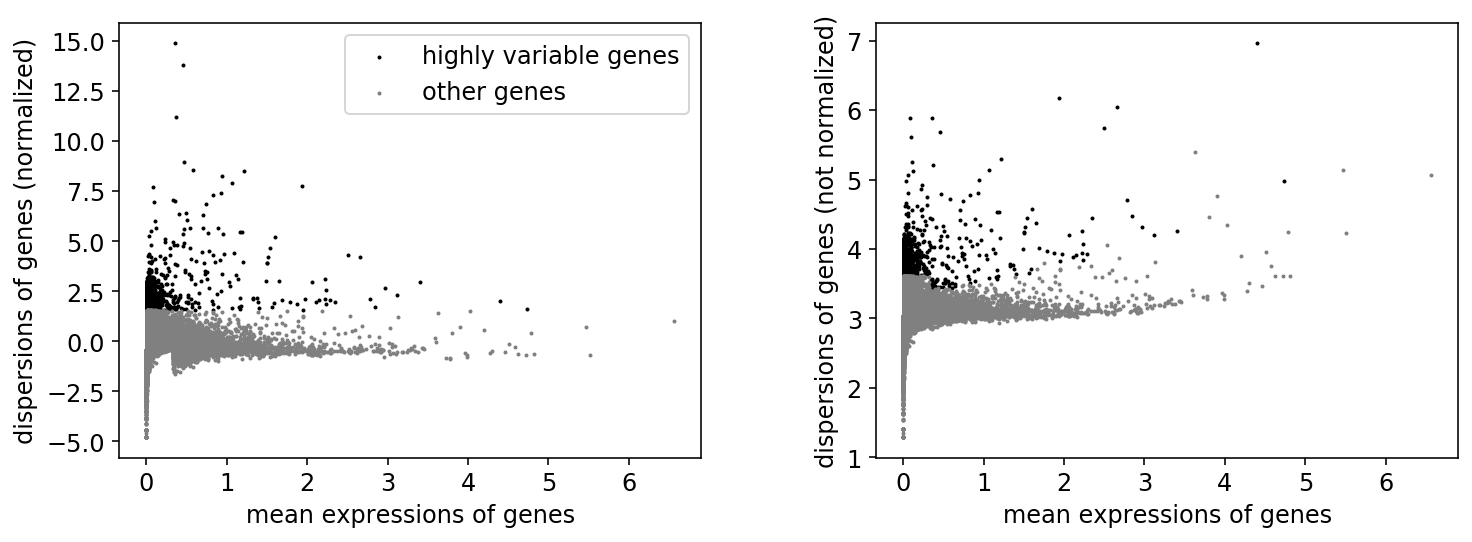

In [0]:
filter_result = sc.pp.highly_variable_genes(adata, min_disp=0.3, inplace=False, n_top_genes=1209)
sc.pl.highly_variable_genes(filter_result)

In [0]:
print("{:,} highly variable genes".format(sum(x[0] for x in filter_result)))

1,209 highly variable genes


### Louvain clustering and visualization

In [0]:
%%time
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.louvain(adata)

CPU times: user 33 s, sys: 3.34 s, total: 36.3 s
Wall time: 22.1 s


### PCA

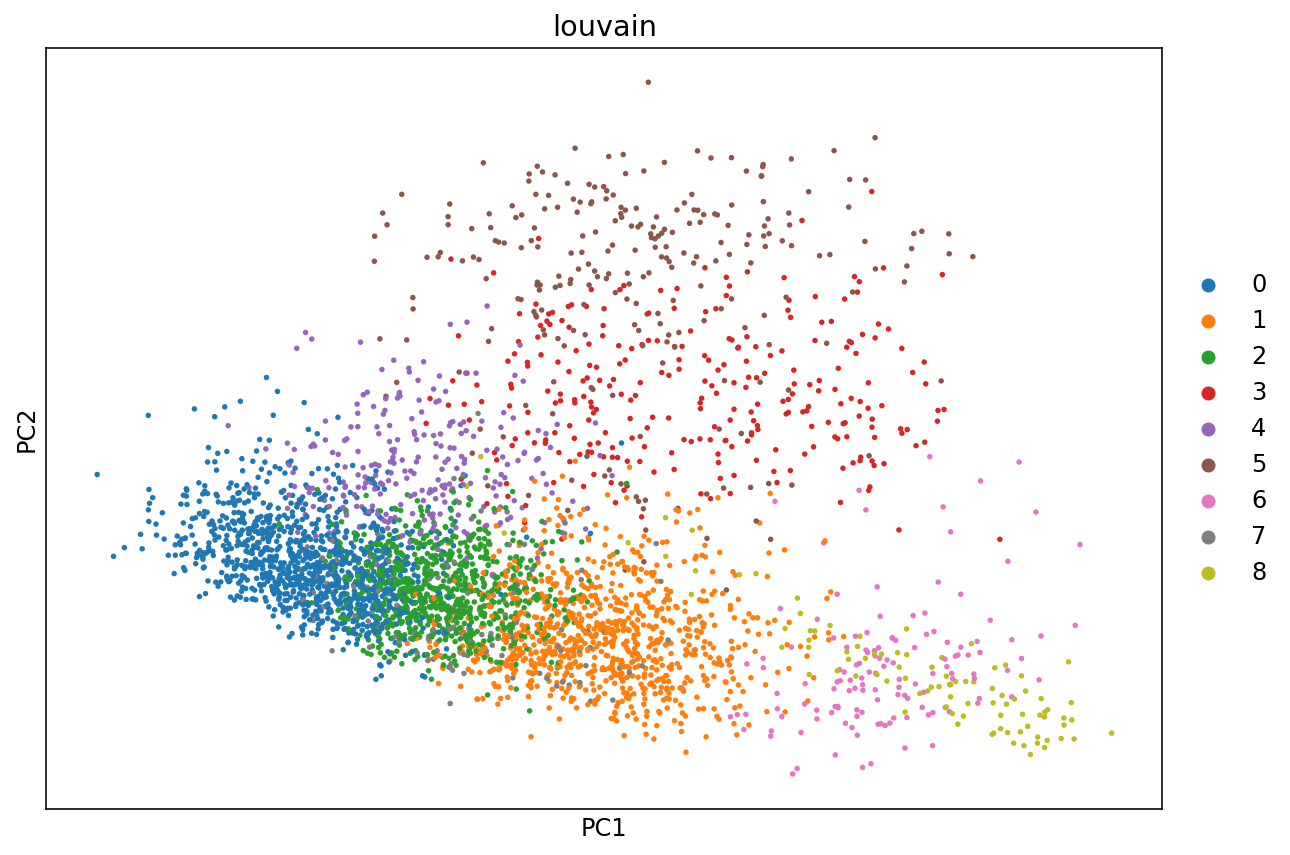

In [0]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

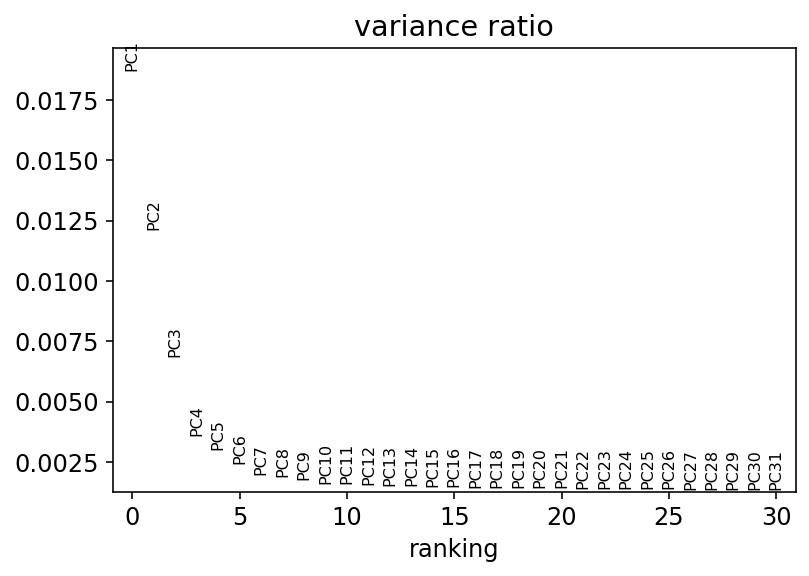

In [0]:
sc.pl.pca_variance_ratio(adata)

### UMAP

In [0]:
%%time
sc.tl.umap(adata)

CPU times: user 12.5 s, sys: 167 ms, total: 12.7 s
Wall time: 12.5 s


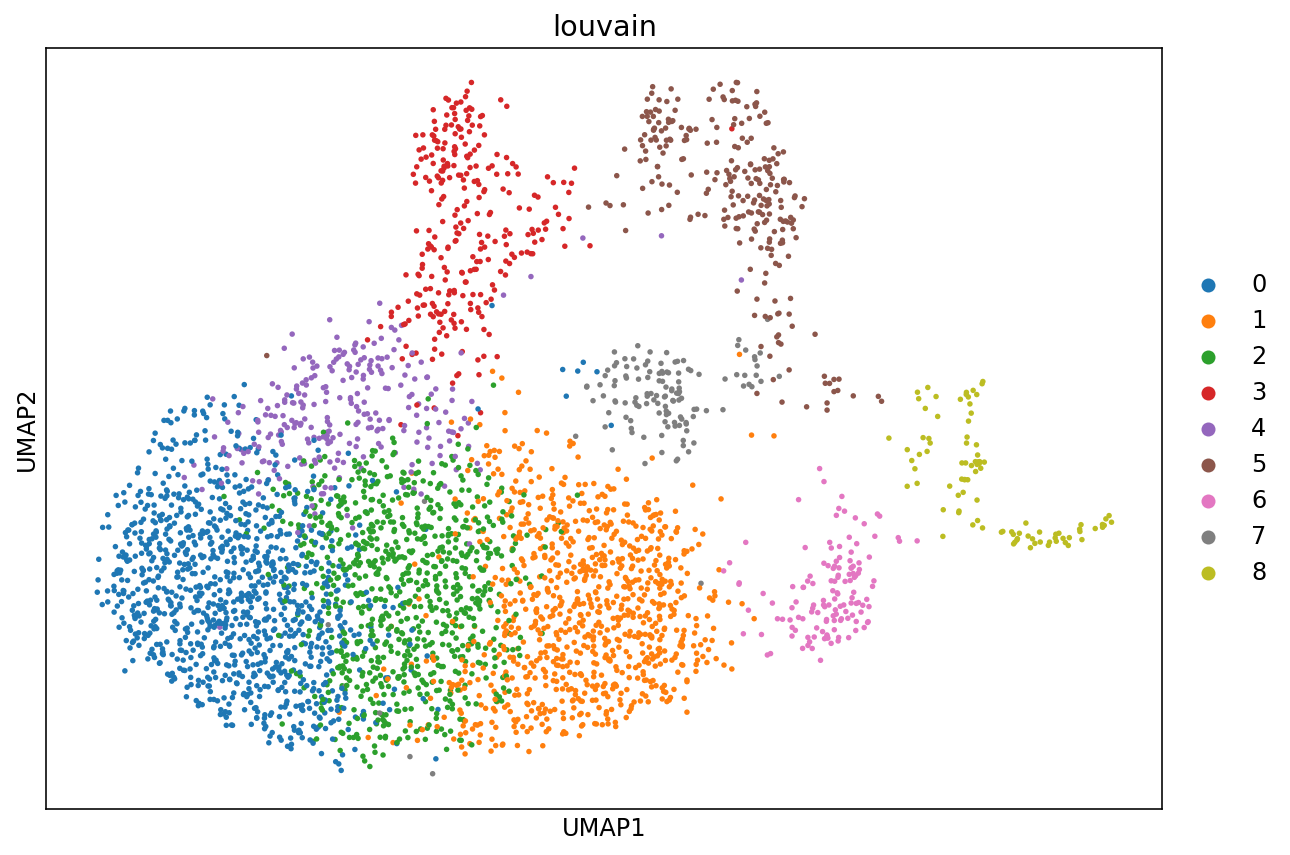

In [0]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)

### tSNE

In [0]:
%%time
sc.tl.tsne(adata, n_pcs=10)

CPU times: user 37.1 s, sys: 106 ms, total: 37.2 s
Wall time: 37.3 s


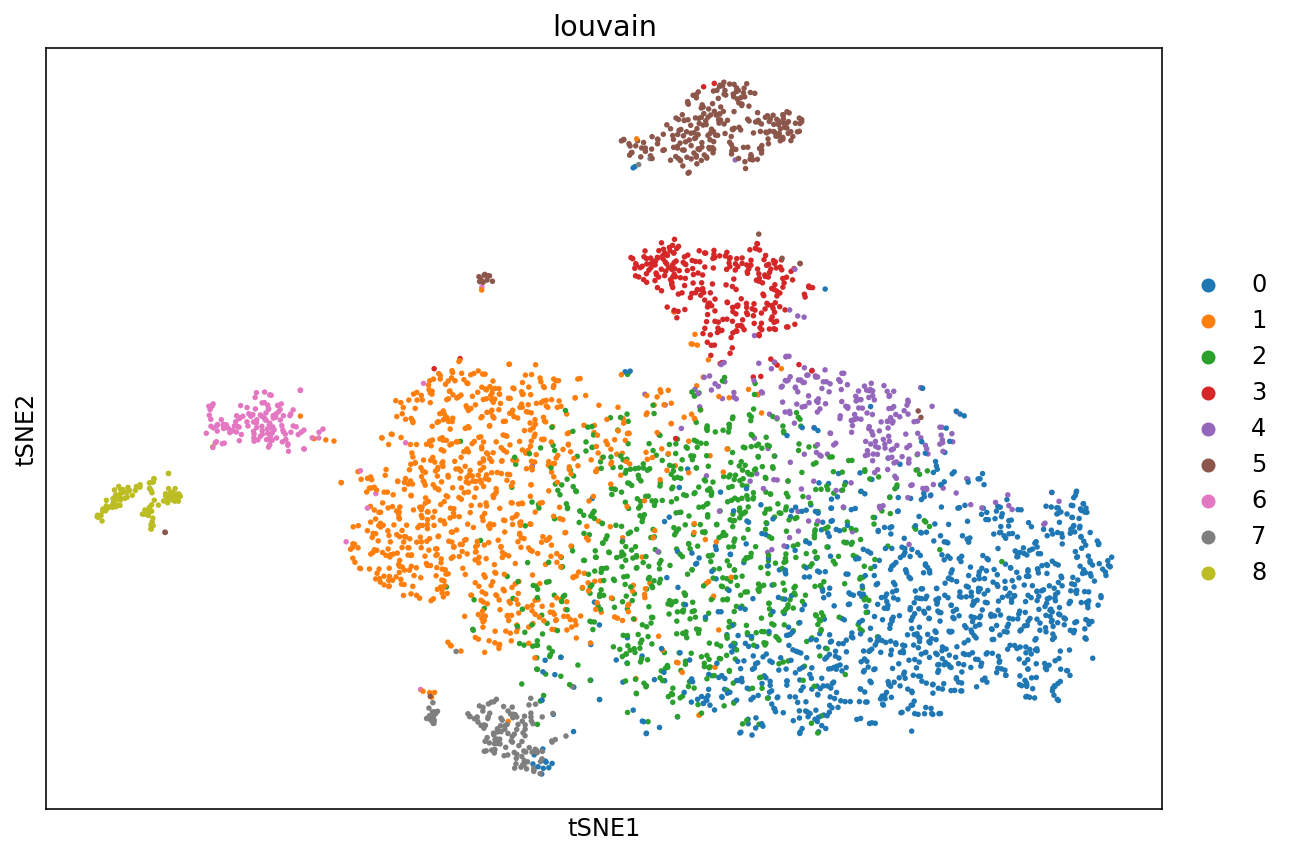

In [0]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax)